In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/623.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/764.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/1075.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/771.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/208.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/820.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/473.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/1031.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/333.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/1024.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/537.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/45.jpg
/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal/369.jpg
/kaggle/in

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-09-25 19:25:20.038746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758828320.236627      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758828320.293578      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [3]:
from tensorflow.keras.applications.efficientnet import preprocess_input as ef_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as res_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as dense_preprocess


In [4]:
# Generate data paths with labels
data_dir = '/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image' 
filepaths = []
labels = []

folds = os.listdir(data_dir) 
for fold in folds:
    foldpath = os.path.join(data_dir, fold) 
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file) 
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df

,filepaths,labels
0,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
1,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
2,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
3,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
4,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
...,...,...
3470,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Viral Pneumonia
3471,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Viral Pneumonia
3472,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Viral Pneumonia
3473,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Viral Pneumonia


In [6]:
df['labels'].value_counts()

labels
Normal             1250
Lung_Opacity       1125
Viral Pneumonia    1100
Name: count, dtype: int64

In [7]:
strat = df['labels']
train_df, test_df = train_test_split(df, train_size= 0.7, shuffle= True, stratify= strat, random_state= 123)

In [8]:
train_df.shape, test_df.shape

((2432, 2), (1043, 2))

In [9]:
train_df

,filepaths,labels
2178,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
3090,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Viral Pneumonia
780,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
687,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
47,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
...,...,...
1969,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
2195,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
75,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
995,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal


In [10]:
train_df['labels'].value_counts()

labels
Normal             875
Lung_Opacity       787
Viral Pneumonia    770
Name: count, dtype: int64

In [11]:
test_df

,filepaths,labels
1202,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
2870,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Viral Pneumonia
2076,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
2019,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
1888,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
...,...,...
2909,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Viral Pneumonia
1672,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
2353,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Lung_Opacity
996,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal


In [12]:
valid, test = train_test_split(test_df, train_size = 0.5, shuffle = True, random_state = 45 )

In [13]:
test.shape , valid.shape

((522, 2), (521, 2))

In [16]:
test['labels'].value_counts()


labels
Normal             176
Lung_Opacity       175
Viral Pneumonia    171
Name: count, dtype: int64

In [17]:
valid['labels'].value_counts()

labels
Normal             199
Lung_Opacity       163
Viral Pneumonia    159
Name: count, dtype: int64

In [18]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

datagen_lung = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=False,       # optional
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator()


In [19]:
train_generator = datagen_lung.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size= img_size,
    batch_size= batch_size ,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=True
)

val_generator = val_test_gen.flow_from_dataframe(
    dataframe=valid,
    x_col='filepaths',
    y_col='labels',
    target_size= img_size,
    batch_size= batch_size ,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=True
    
)

test_generator = val_test_gen.flow_from_dataframe(dataframe =test ,
                                      x_col= 'filepaths',
                                      y_col = 'labels' ,
                                      target_size = img_size , 
                                      class_mode = 'categorical' ,
                                      color_mode= 'rgb' ,
                                      shuffle = False ,
                                      batch_size = batch_size)

Found 2432 validated image filenames belonging to 3 classes.
Found 521 validated image filenames belonging to 3 classes.
Found 522 validated image filenames belonging to 3 classes.


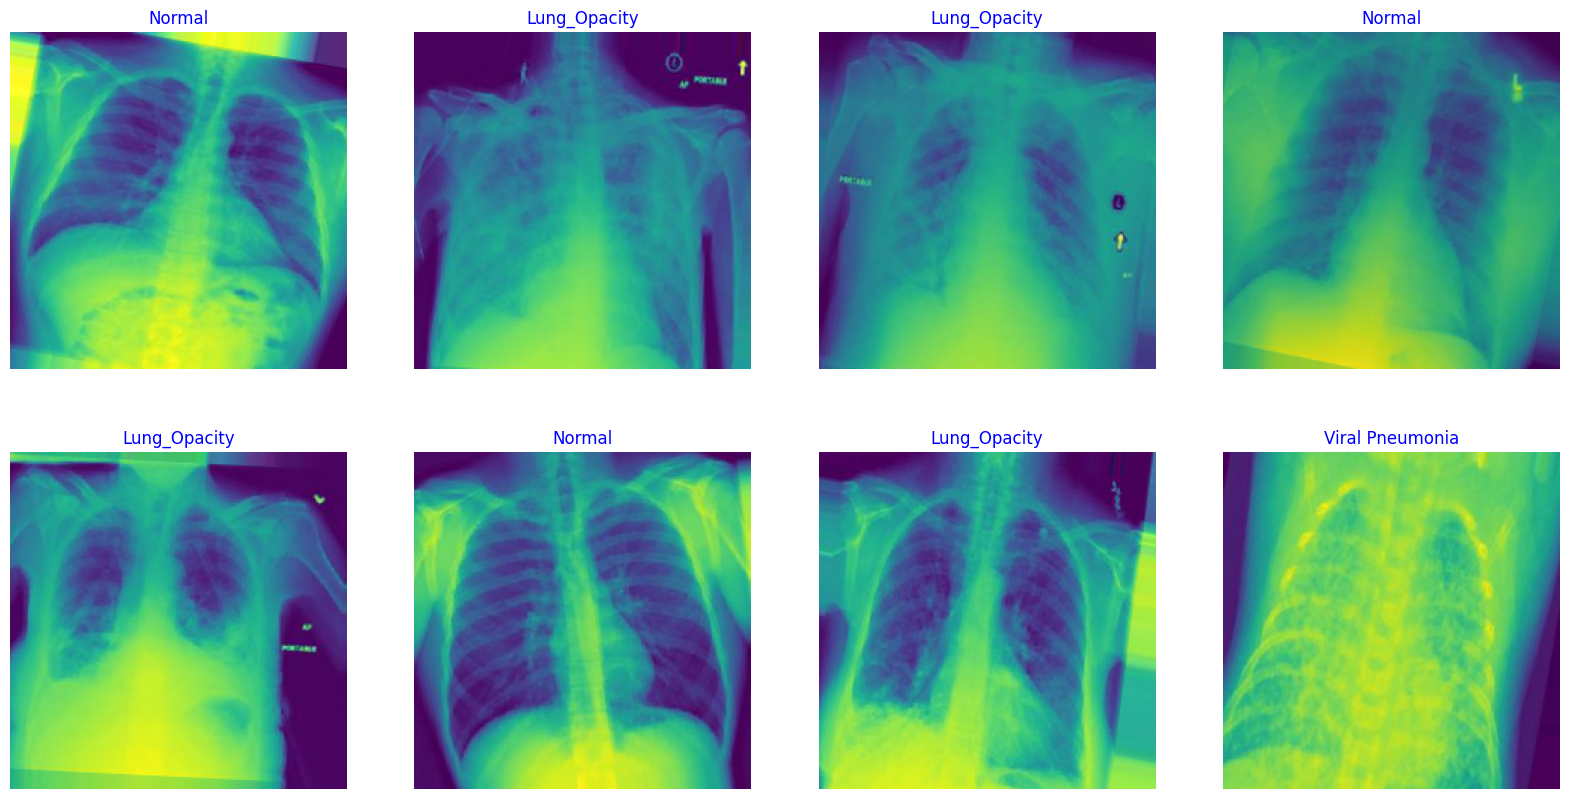

In [20]:
g_dict = train_generator.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_generator)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [21]:
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape= img_shape,
    pooling='max',
)

densenet_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'), 
    Dropout(0.5),  
    Dense(num_class, activation='softmax')
])

densenet_model.compile(optimizer=Adamax(learning_rate=0.0005),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

densenet_model.summary()

I0000 00:00:1758828794.974955      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758828794.975759      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,304,771 (27.87 MB)

 Trainable params: 7,219,075 (27.54 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [22]:
epochs = 20
densenet_history = densenet_model.fit(x= train_generator, epochs = epochs, verbose = 1 , validation_data = val_generator,
                   validation_steps = None , shuffle = False)

Epoch 1/20


I0000 00:00:1758828920.234013     113 service.cc:148] XLA service 0x7a9ca0002b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758828920.234818     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758828920.234839     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758828927.467177     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758829003.328294     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 ━━━━━━━━━━━━━━━━━━━━ 234s 451ms/step - accuracy: 0.7108 - loss: 0.7170 - val_accuracy: 0.8676 - val_loss: 0.3180
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 227ms/step - accuracy: 0.8811 - loss: 0.3358 - val_accuracy: 0.8676 - val_loss: 0.3094
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 231ms/step - accuracy: 0.8970 - loss: 0.2898 - val_accuracy: 0.9040 - val_loss: 0.2413
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 229ms/step - accuracy: 0.8887 - loss: 0.2959 - val_accuracy: 0.8714 - val_loss: 0.3067
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 34s 223ms/step - accuracy: 0.9273 - loss: 0.2016 - val_accuracy: 0.9060 - val_loss: 0.3138
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step - accuracy: 0.9215 - loss: 0.2084 - val_accuracy: 0.9194 - val_loss: 0.2145
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - accuracy: 0.9360 - loss: 0.1706 - val_accuracy: 0.9251 - val_loss: 0.1999
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - accuracy: 0.9380 - loss: 0.1690 - va

In [23]:
train_acc = densenet_history.history['accuracy']
train_loss = densenet_history.history['loss']
val_acc = densenet_history.history['val_accuracy']
val_loss = densenet_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

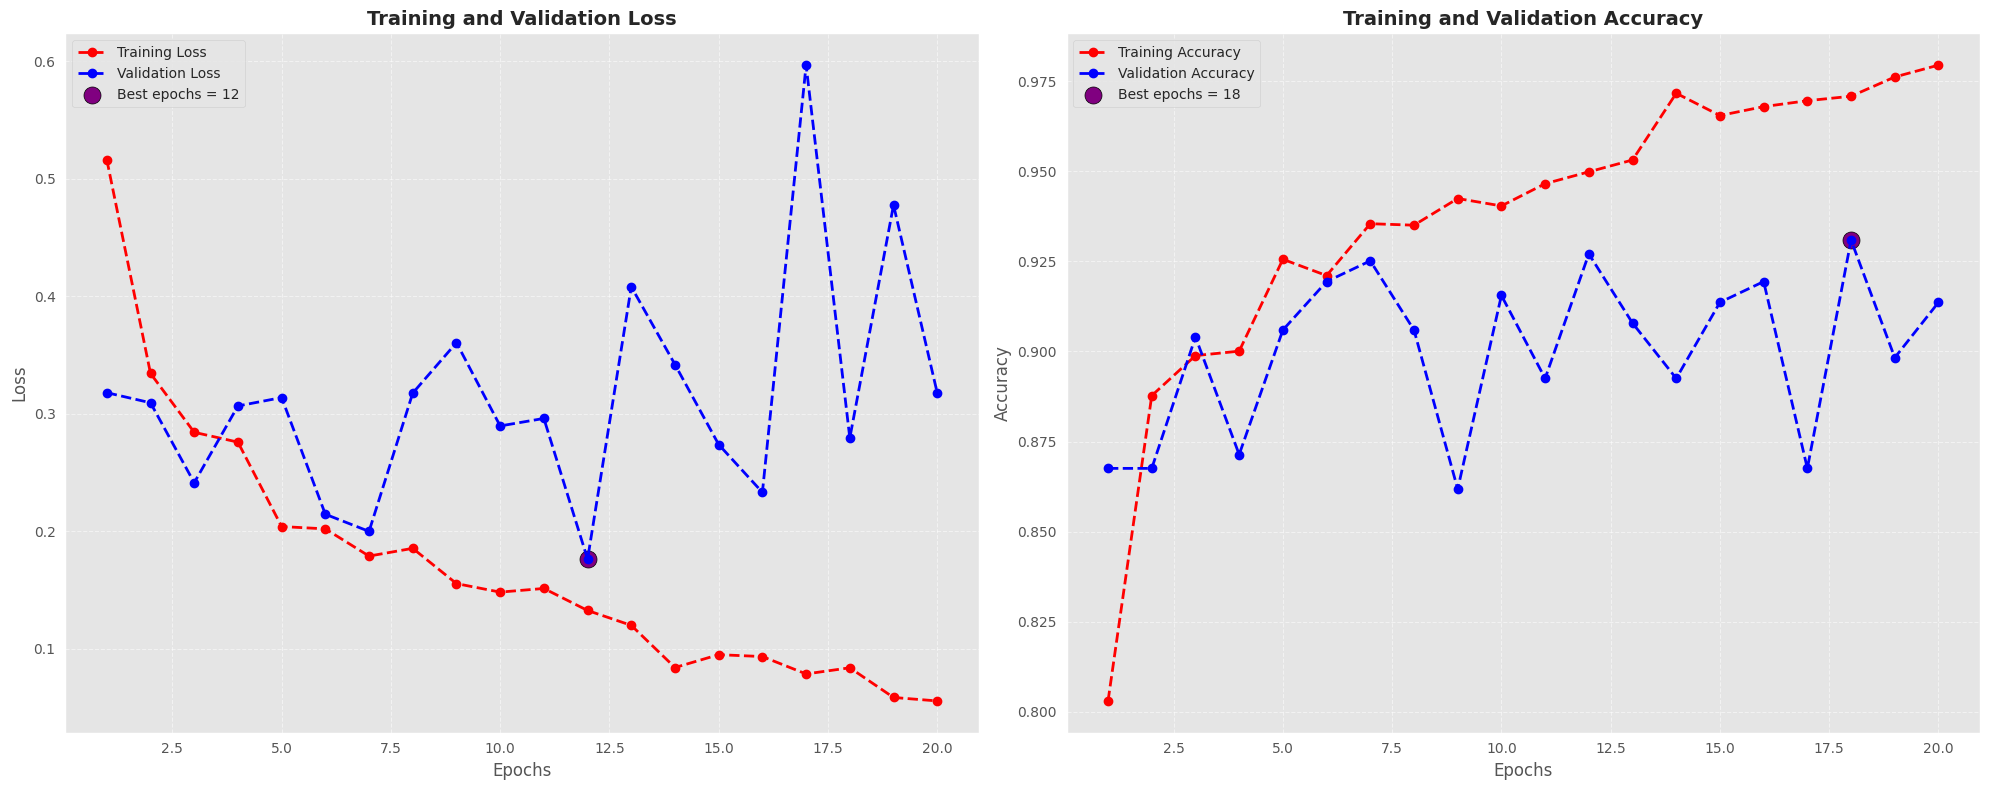

In [24]:
plt.figure(figsize=(20, 8))
plt.style.use("ggplot")

#Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r--', linewidth=2, marker='o', label='Training Loss')
plt.plot(Epochs, val_loss, 'b--', linewidth=2, marker='o', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='purple', edgecolors='black', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

#Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r--', linewidth=2, marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b--', linewidth=2, marker='o', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='purple', edgecolors='black', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()


In [25]:
train_score = densenet_model.evaluate(train_generator , steps =16 , verbose = 1)
valid_score = densenet_model.evaluate(val_generator , steps = 16 , verbose = 1)
test_score = densenet_model.evaluate(test_generator , steps = 16 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9567 - loss: 0.1045
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.2951
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9634 - loss: 0.1365
Train Loss:  0.07111836969852448
Train Accuracy:  0.96484375
--------------------
Validation Loss:  0.3422882556915283
Validation Accuracy:  0.91796875
--------------------
Test Loss:  0.16426338255405426
Test Accuracy:  0.953125


33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 542ms/step


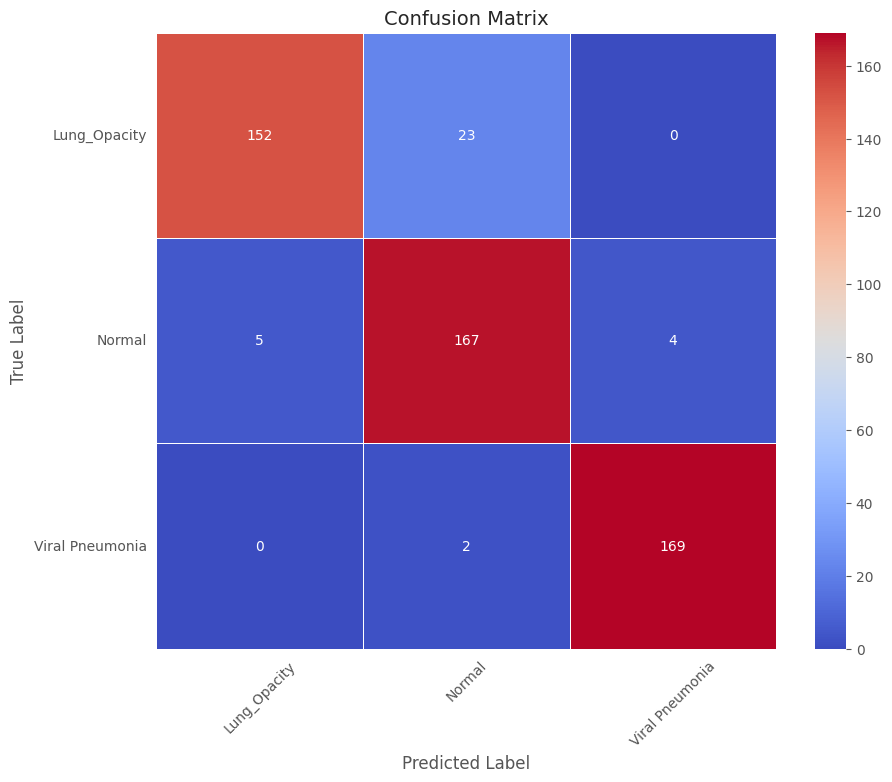

In [26]:
preds = densenet_model.predict(test_generator)  
y_pred = np.argmax(preds, axis=1)
# Get class labels
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Compute Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=classes, yticklabels=classes, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [27]:
print(classification_report(test_generator.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

   Lung_Opacity       0.97      0.87      0.92       175
         Normal       0.87      0.95      0.91       176
Viral Pneumonia       0.98      0.99      0.98       171

       accuracy                           0.93       522
      macro avg       0.94      0.94      0.94       522
   weighted avg       0.94      0.93      0.93       522



In [28]:
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='avg'
)


efficient_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(num_class, activation='softmax')
])

efficient_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

efficient_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,398 (16.72 MB)

 Trainable params: 4,338,815 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [29]:
epochs = 20
efficient_history = efficient_model.fit(x= train_generator, epochs = epochs, verbose = 1 , validation_data = val_generator ,
                   validation_steps = None ,shuffle = False)

Epoch 1/20


E0000 00:00:1758829876.389467     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758829876.529314     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758829876.917946     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758829877.060028     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


152/152 ━━━━━━━━━━━━━━━━━━━━ 129s 275ms/step - accuracy: 0.6328 - loss: 1.3440 - val_accuracy: 0.8580 - val_loss: 0.8387
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.8415 - loss: 0.8812 - val_accuracy: 0.9002 - val_loss: 0.7470
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.8757 - loss: 0.7486 - val_accuracy: 0.9040 - val_loss: 0.7153
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.8930 - loss: 0.6859 - val_accuracy: 0.9021 - val_loss: 0.6977
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.9111 - loss: 0.6706 - val_accuracy: 0.9079 - val_loss: 0.7049
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9195 - loss: 0.6453 - val_accuracy: 0.9251 - val_loss: 0.6474
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy: 0.9239 - loss: 0.6058 - val_accuracy: 0.9136 - val_loss: 0.6775
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.9403 - loss: 0.5441 - va

In [30]:
train_acc = efficient_history.history['accuracy']
train_loss = efficient_history.history['loss']
val_acc = efficient_history.history['val_accuracy']
val_loss = efficient_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

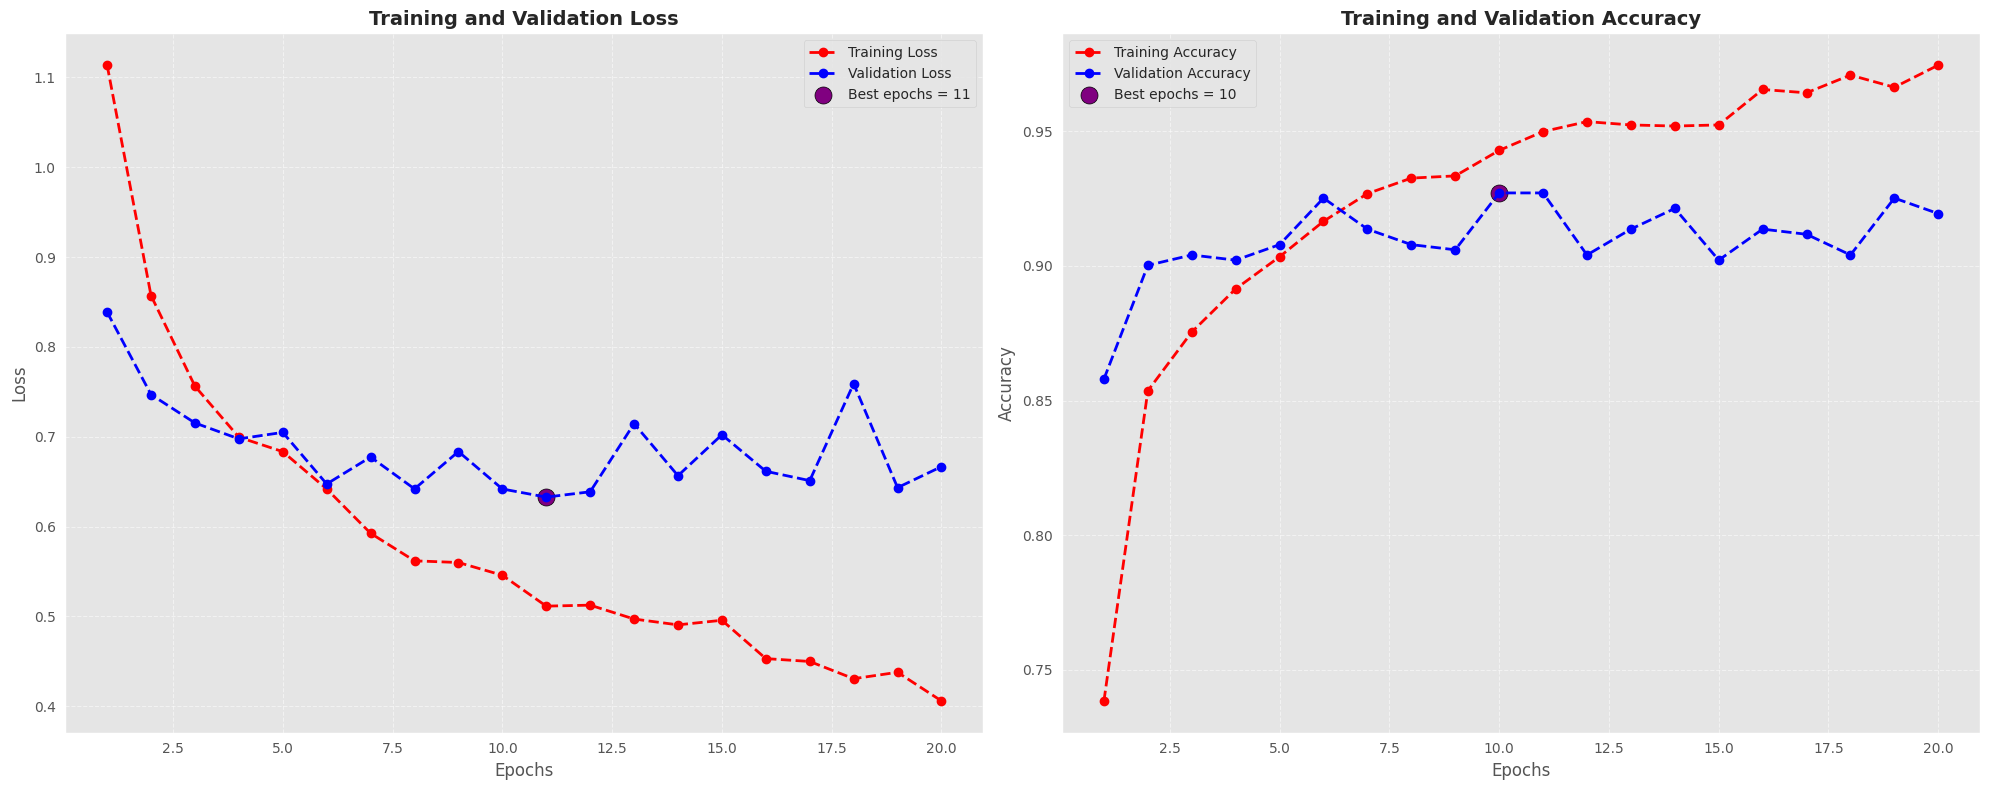

In [31]:
plt.figure(figsize=(20, 8))
plt.style.use("ggplot")

#Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r--', linewidth=2, marker='o', label='Training Loss')
plt.plot(Epochs, val_loss, 'b--', linewidth=2, marker='o', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='purple', edgecolors='black', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

#Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r--', linewidth=2, marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b--', linewidth=2, marker='o', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='purple', edgecolors='black', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()


In [32]:
train_score = efficient_model.evaluate(train_generator , steps =16 , verbose = 1)
valid_score = efficient_model.evaluate(val_generator , steps = 16 , verbose = 1)
test_score = efficient_model.evaluate(test_generator , steps = 16 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9771 - loss: 0.3617
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9349 - loss: 0.6309
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9534 - loss: 0.5524
Train Loss:  0.3561428189277649
Train Accuracy:  0.984375
--------------------
Validation Loss:  0.6375032067298889
Validation Accuracy:  0.92578125
--------------------
Test Loss:  0.5984395742416382
Test Accuracy:  0.94140625


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step


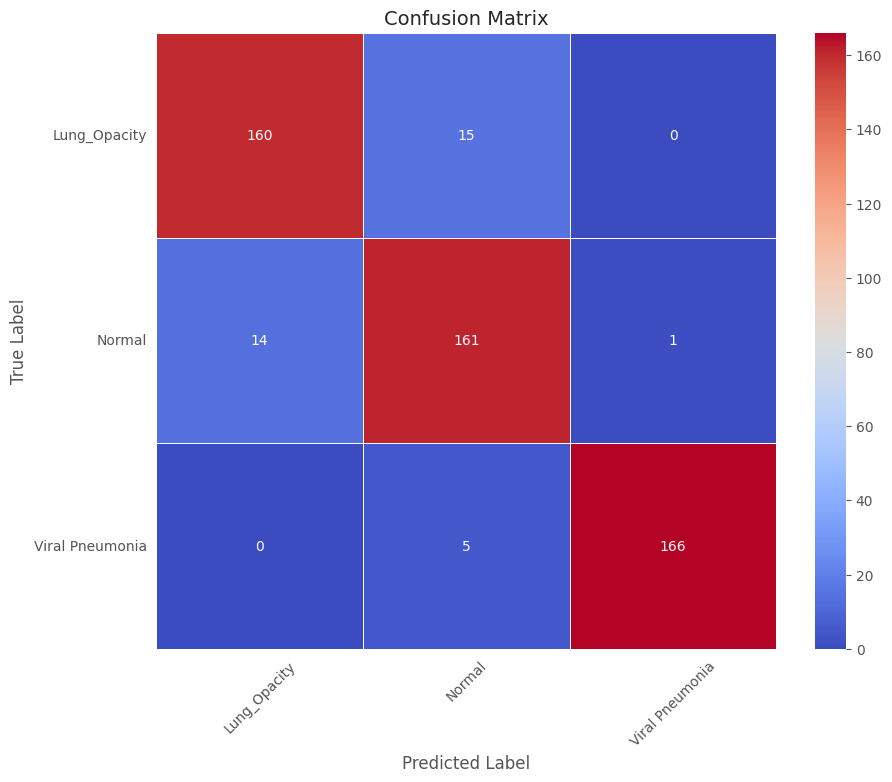

In [33]:
preds = efficient_model.predict(test_generator)  
y_pred = np.argmax(preds, axis=1)
# Get class labels
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Compute Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=classes, yticklabels=classes, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [34]:
print(classification_report(test_generator.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

   Lung_Opacity       0.92      0.91      0.92       175
         Normal       0.89      0.91      0.90       176
Viral Pneumonia       0.99      0.97      0.98       171

       accuracy                           0.93       522
      macro avg       0.93      0.93      0.93       522
   weighted avg       0.93      0.93      0.93       522



In [35]:
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)


base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max',
)

for layer in base_model.layers:
    layer.trainable = False

resnet_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_class, activation='softmax')
])

resnet_model.compile(optimizer= Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,219 (92.02 MB)

 Trainable params: 529,411 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [36]:
epochs = 20
resnet_history = resnet_model.fit(x= train_generator, epochs = epochs, verbose = 1 , validation_data = val_generator ,
                   validation_steps = None ,shuffle = False)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 254ms/step - accuracy: 0.6675 - loss: 0.8153 - val_accuracy: 0.8464 - val_loss: 0.3962
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.8375 - loss: 0.4257 - val_accuracy: 0.8599 - val_loss: 0.3267
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.8636 - loss: 0.3711 - val_accuracy: 0.8676 - val_loss: 0.3196
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.8842 - loss: 0.3264 - val_accuracy: 0.8752 - val_loss: 0.2951
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.8668 - loss: 0.3351 - val_accuracy: 0.8772 - val_loss: 0.2901
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.8784 - loss: 0.3316 - val_accuracy: 0.8714 - val_loss: 0.2975
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.8834 - loss: 0.2903 - val_accuracy: 0.8829 - val_loss: 0.2814
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.8837 - loss: 0

In [37]:
train_acc = resnet_history.history['accuracy']
train_loss = resnet_history.history['loss']
val_acc = resnet_history.history['val_accuracy']
val_loss = resnet_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

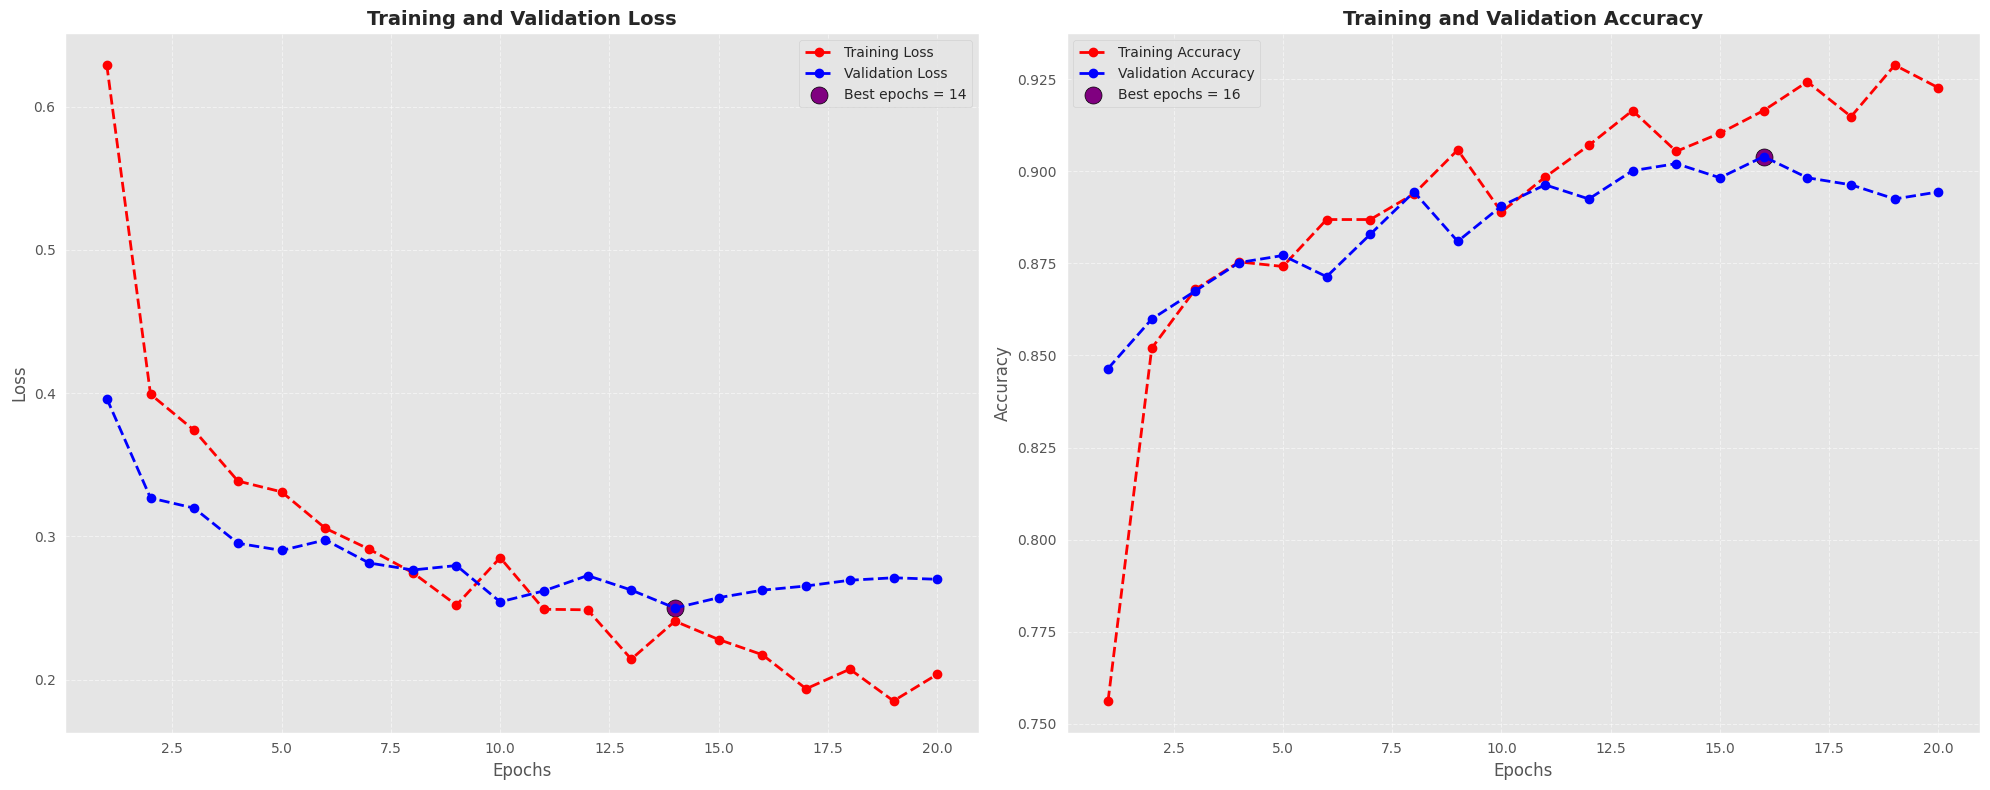

In [38]:
plt.figure(figsize=(20, 8))
plt.style.use("ggplot")

#Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r--', linewidth=2, marker='o', label='Training Loss')
plt.plot(Epochs, val_loss, 'b--', linewidth=2, marker='o', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='purple', edgecolors='black', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

#Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r--', linewidth=2, marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b--', linewidth=2, marker='o', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='purple', edgecolors='black', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()


In [39]:
train_score = resnet_model.evaluate(train_generator , steps =16 , verbose = 1)
valid_score = resnet_model.evaluate(val_generator , steps = 16 , verbose = 1)
test_score = resnet_model.evaluate(test_generator , steps = 16 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.9619 - loss: 0.0786
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8981 - loss: 0.2318
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9351 - loss: 0.1326
Train Loss:  0.08069133758544922
Train Accuracy:  0.9609375
--------------------
Validation Loss:  0.28765663504600525
Validation Accuracy:  0.87890625
--------------------
Test Loss:  0.1721411943435669
Test Accuracy:  0.93359375


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step


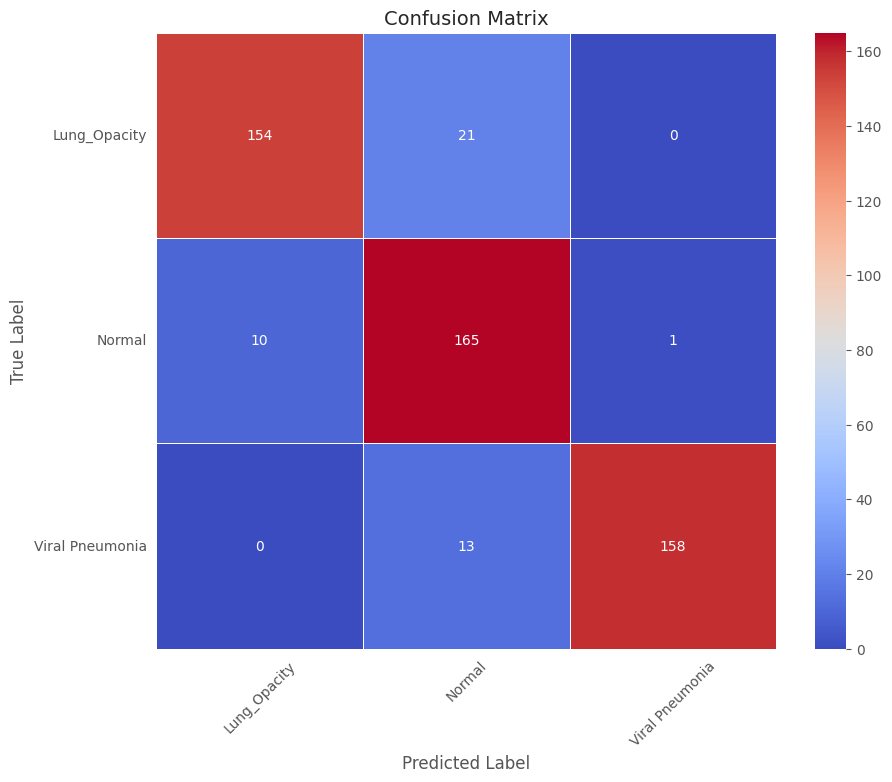

In [40]:
preds = resnet_model.predict(test_generator)  
y_pred = np.argmax(preds, axis=1)
# Get class labels
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Compute Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=classes, yticklabels=classes, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [41]:
print(classification_report(test_generator.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

   Lung_Opacity       0.94      0.88      0.91       175
         Normal       0.83      0.94      0.88       176
Viral Pneumonia       0.99      0.92      0.96       171

       accuracy                           0.91       522
      macro avg       0.92      0.91      0.92       522
   weighted avg       0.92      0.91      0.91       522



In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [47]:
img_path ='/kaggle/input/test-opacity-img/opacity-in-the-right-middle-lung-zone.png'

img = load_img(img_path, target_size=(224, 224))  # resize to model input
x = img_to_array(img)
x = np.expand_dims(x, axis=0)


In [48]:
preds = efficient_model.predict(x)
predicted_class = np.argmax(preds, axis=1)
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[0]


In [51]:
pred_idx = np.argmax(preds, axis=1)[0]
# Map index to class name
idx_to_class = {v:k for k,v in train_generator.class_indices.items()}
predicted_class = idx_to_class[pred_idx]

print(f"Predicted class: {predicted_class}")

Predicted class: Lung_Opacity


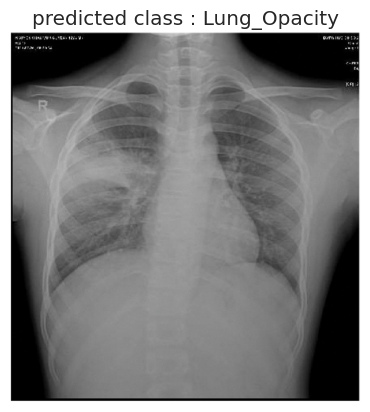

In [52]:
plt.imshow(load_img(img_path))
plt.title(f'predicted class : {predicted_class}')
plt.axis("off")
plt.show()

In [53]:
idx_to_class

{0: 'Lung_Opacity', 1: 'Normal', 2: 'Viral Pneumonia'}

In [55]:
efficient_model.save('/kaggle/working/efficient_model_lung_disease.h5')